In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torchvision import models

from torchsummary import summary # pip install torchsummary

# Trial1 (Encoder ResNet)
- [Code Link](https://github.com/pytorch/vision/blob/v0.2.0/torchvision/models/resnet.py)
- [Paper Link](https://arxiv.org/abs/1512.03385)
    - Refer Table1 for ResNet-18/34/50

In [2]:

def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3(in_channels, channels, stride)
        self.bn1   = nn.BatchNorm2d(channels)
        self.relu  = nn.ReLU(inplace=True)
        
        self.conv2 = conv3x3(channels, channels)
        self.bn2   = nn.BatchNorm2d(channels)
        
        self.downsample = downsample
        self.stride     = stride
    
    def forward(self, x):
        identity = x
        out      = self.conv1(x)
        out      = self.bn1(out)
        out      = self.relu(out)
        
        out      = self.conv2(out)
        out      = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out  += identity
        out = self.relu(out)
        
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1   = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2   = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3   = nn.BatchNorm2d(planes * self.expansion)
        self.relu  = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

    

class ResNet(nn.Module):
    
    def __init__(self, block, layers, num_classes=10, zero_init_residual=False):
        super(ResNet, self).__init__()

        self.in_channels = 64
        self.conv1 = nn.Conv2d(3,64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1])
        self.layer3 = self._make_layer(block, 256, layers[2])
        self.layer4 = self._make_layer(block, 512, layers[3])

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc      = nn.Linear(512*block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias,0)
        
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m.bin3.weight, 0):
                    nn.init.constant_(m.nbn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight,0)

    def _make_layer(self, block, channels, blocks, stride=1):
        downsample = None
        
        # print ('Stride : ', stride, ' || self.in_channels :', self.in_channels, ' || Channels : ',channels, block.expansion, channels * block.expansion)
        # print (stride != 1, self.in_channels != channels * block.expansion)
        if stride != 1 or self.in_channels != channels * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.in_channels, channels * block.expansion, stride),
                nn.BatchNorm2d(channels * block.expansion)                
            )
        
        layers = []
        layers.append(block(self.in_channels, channels, stride, downsample))
        self.in_channels = channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, channels))

        return nn.Sequential(*layers)
        
    
    def forward(self ,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x 

def resnet18():
    model = ResNet(BasicBlock, [2, 2, 2, 2])
    return model

def resnet34():
    model = ResNet(BasicBlock, [3, 4, 6, 3])
    return model

In [8]:
if __name__ == "__main__":
     
    net18 = resnet18().cuda()  # len(list(net18.children())) = 10
    # net18 = ResNet(Bottleneck, [2, 2, 2, 2])  # len(list(net18.children())) = 10
    summary(net18, input_size=(3, 512, 512))    
    # print (len(list(net18.children())))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

# Trial2 (Encoder-Decoder ResNet)
- [Link](https://github.com/usuyama/pytorch-unet/blob/master/pytorch_resnet18_unet.ipynb)

In [2]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True)
    )

class ResNetUnet(nn.Module):
    
    def __init__(self, n_classes, verbose=0):
        super().__init__()
        
        self.verbose     = verbose 
        
        self.base_model  = models.resnet18(pretrained=False)
        self.base_layers = list(self.base_model.children())
        
        self.layer0      = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1  = convrelu(64,64,1,0)
        
        self.layer1      = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1  = convrelu(64,64,1,0)
        
        self.layer2      = self.base_layers[5]
        # self.layer2_1x1  = convrelu(512, 512, 1,0)
        self.layer2_1x1  = convrelu(128, 64, 1,0)
        
        self.layer3      = self.base_layers[6]
        # self.layer3_1x1  = convrelu(1024,512,1,0)
        self.layer3_1x1  = convrelu(256,128,1,0)
        
        self.layer4      = self.base_layers[7]
        # self.layer4_1x1  = convrelu(2048, 1024,1,0)
        self.layer4_1x1  = convrelu(512, 256,1,0)
        
        self.upsample    = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # self.conv_up3    = convrelu(512+1024 , 512, 3, 1)
        self.conv_up3    = convrelu(128+256 , 128, 3, 1)
        #self.conv_up2    = convrelu(512 + 512, 512, 3, 1) 128+64
        self.conv_up2    = convrelu(128+64, 64, 3, 1)
        #self.conv_up1    = convrelu(256 + 512, 256, 3, 1)
        self.conv_up1    = convrelu(64 + 64, 64, 3, 1)
        # self.conv_up0    = convrelu(64 + 256 , 128, 3, 1)
        self.conv_up0    = convrelu(64 + 64 , 64, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 32, 3, 1)
        self.conv_original_size1 = convrelu(32, 64, 3, 1)
        self.conv_original_size2 = convrelu(128, 64, 3, 1)
        
        self.conv_last   = nn.Conv2d(64, n_classes, 1)
    
    def forward(self, x_input):
        if self.verbose: print ('Preprocess : x_input    : ', x_input.shape)
        x_original = self.conv_original_size0(x_input)
        if self.verbose: print ('Preprocess : x_original : ', x_original.shape)
        x_original = self.conv_original_size1(x_original)
        if self.verbose: print ('Preprocess : x_original : ', x_original.shape)
        
        
        
        layer0 = self.layer0(x_input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)
        
        if self.verbose:
            print ('\nEncoder : Layer0 : ', layer0.shape)
            print ('Encoder : Layer1 : ', layer1.shape)
            print ('Encoder : Layer2 : ', layer2.shape)
            print ('Encoder : Layer3 : ', layer3.shape)
            print ('Encoder : Layer4 : ', layer4.shape)
        
        layer4 = self.layer4_1x1(layer4)
        if self.verbose: print ('\nDecoder : Layer4 : ', layer4.shape)
        
        x      = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x      = torch.cat([x, layer3], dim=1)
        x      = self.conv_up3(x)
        if self.verbose: print ('Decoder : Layer3 : ', x.shape)
                
        x      = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x      = torch.cat([x, layer2], dim=1)
        x      = self.conv_up2(x)
        if self.verbose: print ('Decoder : Layer2 : ', x.shape)
        
        x      = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x      = torch.cat([x, layer1], dim=1)
        x      = self.conv_up1(x)
        if self.verbose: print ('Decoder : Layer1 : ', x.shape) # [1, 64, h/4, w/4]
        
        x      = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x      = torch.cat([x, layer0], dim=1)
        x      = self.conv_up0(x)
        if self.verbose:print ('Decoder : Layer0 : ', x.shape) # [1, 64, h/2, w/2]
        
        x      = self.upsample(x)
        x      = torch.cat([x, x_original], dim=1)
        x      = self.conv_original_size2(x)
        if self.verbose : print ('Decoder : x    : ', x.shape) 
        
        out    = self.conv_last(x)
        if self.verbose : print ('Decoder : out  : ', out.shape)
        
        return F.sigmoid(out)
        

In [3]:
# net = ResNetUnet(1).cuda()
# summary(net, input_size=(3,512, 512)) 


net =  ResNetUnet(1, verbose=1)
# x  = torch.randn(1,3,512,512) # works
# x  = torch.randn(1,3,768,768) # works
x  = torch.randn(1,3,758,758)
y = net(x)
# y.shape
# layers = list(net.children())
# print (len(layers))
 

Preprocess : x_input    :  torch.Size([1, 3, 758, 758])
Preprocess : x_original :  torch.Size([1, 32, 758, 758])
Preprocess : x_original :  torch.Size([1, 64, 758, 758])

Encoder : Layer0 :  torch.Size([1, 64, 379, 379])
Encoder : Layer1 :  torch.Size([1, 64, 190, 190])
Encoder : Layer2 :  torch.Size([1, 128, 95, 95])
Encoder : Layer3 :  torch.Size([1, 256, 48, 48])
Encoder : Layer4 :  torch.Size([1, 512, 24, 24])

Decoder : Layer4 :  torch.Size([1, 256, 24, 24])
Decoder : Layer3 :  torch.Size([1, 128, 48, 48])
torch.Size([1, 64, 95, 95])
torch.Size([1, 128, 96, 96])


/home/strider/anaconda3/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 96 and 95 in dimension 2 at /pytorch/aten/src/TH/generic/THTensorMoreMath.cpp:1333

(3, 758, 758)
(3, 773, 788)
(788, 773, 3)


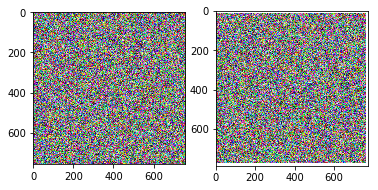

In [94]:
x.shape

# import torch.nn.functional as F
# source = torch.ones((1,3, 5,5))
# print (source)
# # now we expand to size (7, 11) by appending a row of 0s at pos 0 and pos 6, # and a column of 0s at pos 10
# result = F.pad(input=source, pad=(2, 1, 1, 1), mode='constant', value=0)
# print ('=============')
# print (result)
# print (result.shape)

def numpy_pad(ip, pad_x, pad_y, factor):    
    import numpy as np
    if (pad_x == 0):
        print ('Pad_x cannot be zero')
        return ip
    else:
        # op = np.pad(ip,pad_width=(pad_x,pad_y), mode='constant', constant_values=0)
        op = np.pad(ip,pad_width=(pad_x,pad_y), mode='constant', constant_values=0)
        if (pad_y == 0):
            print (op[pad_x:])
            print (op[pad_x:].shape) 
        else:
            print (op)
            print (op.shape)
            print (op[pad_x:-pad_y])
            print (op[pad_x:-pad_x].shape)

import matplotlib.pyplot as plt
def image_pad(ip, pad_x_l=1, pad_x_r=1, pad_y_l=0, pad_y_r=0):
    if (ip.shape[0] == 3):
        r = ip[0,:,:]
        g = ip[1,:,:]
        b = ip[2,:,:]
        r = np.pad(r, pad_width=((pad_x_l, pad_x_r), (pad_y_l, pad_y_r)), mode='constant', constant_values=1)
        g = np.pad(g, pad_width=((pad_x_l, pad_x_r), (pad_y_l, pad_y_r)), mode='constant', constant_values=1)
        b = np.pad(b, pad_width=((pad_x_l, pad_x_r), (pad_y_l, pad_y_r)), mode='constant', constant_values=1)
        
        op = np.zeros((3, r.shape[0], r.shape[1]))
        op[0,:,:] = r
        op[1,:,:] = g
        op[2,:,:] = b
        return op
    
    else:
        print (np.shape)
        print ('Not an image')
        return ip
    
if __name__ == "__main__":

    ip = np.random.rand(3,758, 758)
    print (ip.shape)
    op = image_pad(ip, pad_x_l=0, pad_x_r=15, pad_y_l=15, pad_y_r=15)
    print (op.shape)
    
    f, axarr = plt.subplots(1,2)
    print (op.transpose(-1, 1, 0).shape)
    axarr[0].imshow(ip.transpose(-1, 1, 0))
    axarr[1].imshow(op.transpose(-1, 1, 0))
    plt.show()

In [17]:
import torchvision
torchvision.__version__

'0.2.1'

# Visualization (Ignore)

In [ ]:
import torch
from torch import nn
from torchviz import make_dot, make_dot_from_trace

In [ ]:
model = nn.Sequential()
model.add_module('W0', nn.Linear(8, 16))
model.add_module('tanh', nn.Tanh())
model.add_module('W1', nn.Linear(16, 1))

x = torch.randn(1,8)

make_dot(model(x), params=dict(model.named_parameters()))